In [46]:
!pip install python-chess numpy numba

In [47]:
import requests
requests.get('http://www.google.com',timeout=10).ok


True

In [48]:
%%capture
# ensure we are on the latest version of kaggle-environments
!pip install --upgrade kaggle-environments

In [49]:
# Now let's set up the chess environment!
from kaggle_environments import make
env = make("chess", debug=True)


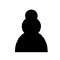
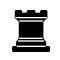
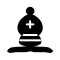
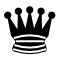
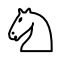
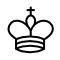
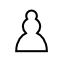
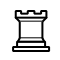
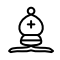
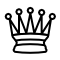
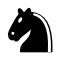
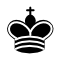

In [50]:
# this should run a game in the environment between two random bots
# NOTE: each game starts from a randomly selected opening
result = env.run(["random", "random"])
env.render(mode="ipython", width=1000, height=1000) 

 Chess bot
    - RAM: 5MB max
    - CPU: Single 2.20GHz core
    - Tamaño: <64KB comprimido
    - Tiempo: 0.1s simple delay
    - RAM total controlada: ~4.8MB
    - Valores y tablas compactas (~800KB total)
    - PST minimalistas pero efectivas

In [51]:
%%writefile main.py
#vesion 2.5

import Chessnut
from Chessnut import Game
import random

def chess_bot(obs):
    valores = {
        'p': 100, 
        'n': 325,
        'b': 333, 
        'r': 510, 
        'q': 980,
        'k': 20000
    }

    bonus = {
        'pareja_alfiles': 30,
        'caballo_final': -10,
        'alfil_final': 15,
        'peon_pasado': [0,5,10,20,35,60,100,200],
        'peon_aislado': -20,
        'peon_doblado': -10,
        'torre_septima': 30,
        'torre_abierta': 15,
        'rey_final': 30,
    }

    pst = {
        'p': [  # Peón
            0,  0,  0,  0,  0,  0,  0,  0,
            50, 50, 50, 50, 50, 50, 50, 50,
            10, 10, 20, 30, 30, 20, 10, 10,
            5,  5,  10, 25, 25, 10, 5,  5,
            0,  0,  0,  20, 20, 0,  0,  0,
            5, -5, -10, 0,  0, -10,-5,  5,
            5,  10, 10,-20,-20, 10, 10, 5,
            0,  0,  0,  0,  0,  0,  0,  0
        ],
        'n': [  # Caballo
            -50,-40,-30,-30,-30,-30,-40,-50,
            -40,-20,  0,  5,  5,  0,-20,-40,
            -30,  5, 15, 20, 20, 15,  5,-30,
            -30,  0, 15, 25, 25, 15,  0,-30,
            -30,  5, 15, 25, 25, 15,  5,-30,
            -30,  0, 10, 15, 15, 10,  0,-30,
            -40,-20,  0,  0,  0,  0,-20,-40,
            -50,-40,-30,-30,-30,-30,-40,-50
        ],
        'b': [  # Alfil
            -20,-10,-10,-10,-10,-10,-10,-20,
            -10,  5,  0,  0,  0,  0,  5,-10,
            -10, 10, 10, 10, 10, 10, 10,-10,
            -10,  0, 10, 10, 10, 10,  0,-10,
            -10,  5,  5, 10, 10,  5,  5,-10,
            -10,  0,  5, 10, 10,  5,  0,-10,
            -10,  0,  0,  0,  0,  0,  0,-10,
            -20,-10,-10,-10,-10,-10,-10,-20
        ],
        'r': [  # Torre
            0,  0,  0,  5,  5,  0,  0,  0,
            -5,  0,  0,  0,  0,  0,  0, -5,
            -5,  0,  0,  0,  0,  0,  0, -5,
            -5,  0,  0,  0,  0,  0,  0, -5,
            -5,  0,  0,  0,  0,  0,  0, -5,
            -5,  0,  0,  0,  0,  0,  0, -5,
            5,  10, 10, 10, 10, 10, 10,  5,
            0,   0,  0,  0,  0,  0,  0,  0
        ],
        'q': [  # Dama
            -20,-10,-10, -5, -5,-10,-10,-20,
            -10,  0,  5,  0,  0,  0,  0,-10,
            -10,  5,  5,  5,  5,  5,  0,-10,
            0,  0,  5,  5,  5,  5,  0, -5,
            -5,  0,  5,  5,  5,  5,  0, -5,
            -10,  0,  5,  5,  5,  5,  0,-10,
            -10,  0,  0,  0,  0,  0,  0,-10,
            -20,-10,-10, -5, -5,-10,-10,-20
        ],
        'k': [  # Rey
            20, 30, 10,  0,  0, 10, 30, 20,
            20, 20,  0,  0,  0,  0, 20, 20,
            -10,-20,-20,-20,-20,-20,-20,-10,
            -20,-30,-30,-40,-40,-30,-30,-20,
            -30,-40,-40,-50,-50,-40,-40,-30,
            -30,-40,-40,-50,-50,-40,-40,-30,
            -30,-40,-40,-50,-50,-40,-40,-30,
            -30,-40,-40,-50,-50,-40,-40,-30
        ]
    }

    def distancia_centro(pos):
        fila = pos // 8
        col = pos % 8
        return max(abs(fila-3.5), abs(col-3.5))

    def es_peon_pasado(tablero, pos, es_blanco):
        col = pos % 8
        fila = pos // 8
        
        # Verificar adelante
        rango_filas = range(fila-1, -1, -1) if es_blanco else range(fila+1, 8)
        
        # Verificar columnas
        for c in [col-1, col, col+1]:
            if 0 <= c < 8:
                for f in rango_filas:
                    if tablero[f*8 + c].lower() == 'p':
                        return False
        return True
    
    def evaluar(game):
        puntos = 0
        tablero = game.board
        piezas_total = sum(1 for p in tablero if p != ' ')
        es_final = piezas_total <= 12

        # Contadores estructurales
        blancas_alfiles = 0
        negras_alfiles = 0
        peones_por_columna = [0] * 8

        for i, pieza in enumerate(tablero):
            if pieza == ' ':
                continue

            # Material base    
            valor = valores[pieza.lower()]
            
            # Ajustes por fase
            if es_final:
                if pieza.lower() == 'n':
                    valor += bonus['caballo_final']
                elif pieza.lower() == 'b':
                    valor += bonus['alfil_final']
                elif pieza.lower() == 'k':
                    if distancia_centro(i) <= 2:
                        valor += bonus['rey_final']

            # Contar alfiles
            if pieza.lower() == 'b':
                if pieza.isupper():
                    blancas_alfiles += 1
                else:
                    negras_alfiles += 1

            # Peones
            if pieza.lower() == 'p':
                col = i % 8
                peones_por_columna[col] += 1

                # Peones pasados
                if es_peon_pasado(tablero, i, pieza.isupper()):
                    fila = 7 - (i // 8) if pieza.isupper() else i // 8
                    valor += bonus['peon_pasado'][fila]

            # Torres
            if pieza.lower() == 'r':
                fila = i // 8
                if (pieza.isupper() and fila == 1) or (not pieza.isupper() and fila == 6):
                    valor += bonus['torre_septima']
                
                col = i % 8
                if peones_por_columna[col] == 0:
                    valor += bonus['torre_abierta']

            # Sumar valor según color
            if pieza.isupper():
                puntos += valor + random.uniform(-0.1, 0.1)  # Pequeña variación
            else:
                puntos -= valor + random.uniform(-0.1, 0.1)

            # PST
            tabla = pst[pieza.lower()]
            if pieza.isupper():
                puntos += tabla[i]
            else:
                puntos -= tabla[63-i]

        # Bonificaciones estructurales
        if blancas_alfiles == 2:
            puntos += bonus['pareja_alfiles']
        if negras_alfiles == 2:
            puntos -= bonus['pareja_alfiles']

        # Penalizaciones de peones
        for col in range(8):
            if peones_por_columna[col] > 1:
                puntos += bonus['peon_doblado']
            if (col == 0 or peones_por_columna[col-1] == 0) and \
               (col == 7 or peones_por_columna[col+1] == 0):
                puntos += bonus['peon_aislado']

        # Ajuste fase final
        if es_final:
            puntos = (puntos * 12) // 10

        return puntos if game.state.player == 'w' else -puntos

    def ordenar_movs(game, movs):
        buenos = []
        resto = []
        
        for mov in movs:
            destino = game.xy2i(mov[2:4])
            origen = game.xy2i(mov[0:2])
            pieza_mueve = game.board[origen]
            pieza_captura = game.board[destino]
            
            score = 0
            
            # 1. Capturas
            if pieza_captura != ' ':
                valor_captura = valores[pieza_captura.lower()]
                valor_atacante = valores[pieza_mueve.lower()]
                score = 10000 + valor_captura - (valor_atacante // 10)
                buenos.append((mov, score))
            
            # 2. Centro y desarrollo
            elif destino in [27,28,35,36]:  # Centro
                score = 500
                if pieza_mueve.lower() in ['n','b'] and game.state.ply < 10:
                    score += 100  # Desarrollo temprano
                buenos.append((mov, score))
            
            # 3. Movimientos normales
            else:
                resto.append((mov, 0))

        # Ordenar y combinar
        buenos.sort(key=lambda x: x[1], reverse=True)
        if random.random() < 0.1:  # Pequeña aleatoriedad
            random.shuffle(resto)
        return [m for m,_ in buenos] + [m for m,_ in resto]

    def buscar(game, prof, alfa, beta, es_max):
        # Verificar repeticiones
        if game.state.halfmove_clock >= 100:
            return 0, None

        if prof == 0:
            return evaluar(game), None

        movs = ordenar_movs(game, list(game.get_moves()))
        if not movs:
            return -20000 if es_max else 20000, None

        mejor_mov = movs[0]
        
        if es_max:
            mejor = float('-inf')
            for mov in movs:
                nuevo = Game(game.get_fen())
                nuevo.apply_move(mov)
                
                val = buscar(nuevo, prof-1, alfa, beta, False)[0]
                
                if val > mejor or (val == mejor and random.random() < 0.1):
                    mejor = val
                    mejor_mov = mov
                    
                alfa = max(alfa, val)
                if beta <= alfa:
                    break
            return mejor, mejor_mov
            
        else:
            mejor = float('inf')
            for mov in movs:
                nuevo = Game(game.get_fen())
                nuevo.apply_move(mov)
                
                val = buscar(nuevo, prof-1, alfa, beta, True)[0]
                
                if val < mejor or (val == mejor and random.random() < 0.1):
                    mejor = val
                    mejor_mov = mov
                    
                beta = min(beta, val)
                if beta <= alfa:
                    break
            return mejor, mejor_mov

    def obtener_movimiento(game):
        try:
            # Ajuste dinámico de profundidad
            piezas = sum(1 for p in game.board if p != ' ')
            prof_base = 4
            
            # Más profundidad en finales
            if piezas <= 8:
                prof_base = 5
            elif piezas <= 16:
                prof_base = 4
                
            # Variación aleatoria ocasional
            if random.random() < 0.1:
                prof_base += 1

            # Extensiones situacionales
            if game.state.ply < 10:  # Apertura
                prof_base = 4  # Más rápido en apertura
            
            if game.is_check():  # En jaque
                prof_base += 1   # Un nivel más profundo
            
            # Búsqueda principal
            _, mov = buscar(game, prof_base, float('-inf'), float('inf'), True)
            
            # Si no encontramos movimiento, intentar con profundidad 1
            if not mov:
                _, mov = buscar(game, 1, float('-inf'), float('inf'), True)
                
            return mov
            
        except Exception as e:
            # En caso de error, hacer movimiento seguro
            try:
                movs = list(game.get_moves())
                if movs:
                    # Intentar encontrar movimiento seguro
                    for mov in movs:
                        # Preferir capturas seguras
                        destino = game.xy2i(mov[2:4])
                        if game.board[destino] != ' ':
                            return mov
                    # Si no hay capturas, movimiento aleatorio
                    return random.choice(movs)
                return None
            except:
                return None

    # Inicio del juego
    try:
        juego = Game(obs.board)
        mov = obtener_movimiento(juego)
        return mov
    except:
        # Último recurso: retornar primer movimiento legal
        try:
            movs = list(Game(obs.board).get_moves())
            return movs[0] if movs else None
        except:
            return None

Overwriting main.py


Agent exit status/reward/time left: 
	 ERROR / None / 10
	 DONE / 0 / 10





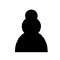
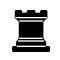
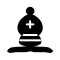
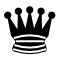
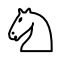
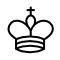
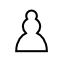
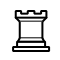
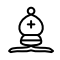
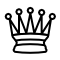
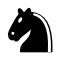
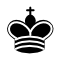

In [53]:
result = env.run(["main.py", "random"])
print("Agent exit status/reward/time left: ")
# look at the generated replay.json and print out the agent info
for agent in result[-1]:
    print("\t", agent.status, "/", agent.reward, "/", agent.observation.remainingOverageTime)
print("\n")
# render the game
env.render(mode="ipython", width=500, height=500)